In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [272]:
sample_info = pd.read_csv('~/Google Drive/Research Projects/Finished/LysisBuffers/data_exchange/lysis-buffer-samples.csv', index_col=0)
counts = pd.read_csv('~/Google Drive/Research Projects/Finished/LysisBuffers/data_exchange/lysis-buffer-counts.csv', index_col=0)
counts = counts.pipe(np.round).astype(int)
counts = counts[sample_info.index]

In [273]:
idx = counts.pipe(np.log1p).var(1).sort_values(ascending=False).head(100).index

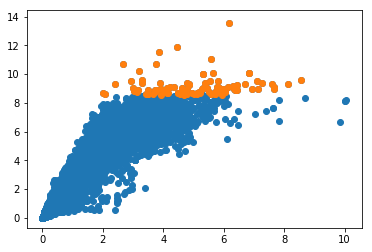

In [274]:
mus = counts.pipe(np.log1p).mean(1)
vas = counts.pipe(np.log1p).var(1)
plt.scatter(mus, vas);
plt.scatter(mus[idx], vas[idx]);

In [275]:
import patsy

Y = patsy.dmatrix('np.log1p(MT_content) + percent_mapped + sample_type', sample_info, return_type='dataframe')
y = np.asarray(Y)

In [276]:
hv_counts = counts.loc[idx]

In [277]:
Y_ = Y.join(pd.DataFrame({'cell': Y.index}, index=Y.index))
long_data = pd.melt(hv_counts.T.join(Y_), id_vars=Y_.columns.tolist()).dropna()
covars = long_data.drop(['variable', 'value', 'cell'], 1)
genes = long_data.variable.astype('category')
cells = long_data.cell.astype('category')
y = long_data.value.values

In [278]:
import pickle

with open('zinb-wave.pkl', 'rb') as fh:
    model = pickle.load(fh)

In [279]:
N = y.shape[0]
P = covars.shape[1]
G = genes.cat.categories.shape[0]
C = cells.cat.categories.shape[0]
data = {
    'N': N,
    'P': P,
    'K': 2,
    'G': G,
    'C': C,
    'x': covars.values,
    'y': y,
    'gene': genes.cat.codes.values + 1,
    'cell': cells.cat.codes.values + 1
}

In [280]:
v = model.vb(data=data, iter=2000)

In [281]:
df = pd.read_csv(v['args']['sample_file'].decode('ascii'), comment='#').dropna()
sdf = df.mean()

/Users/vs4/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [282]:
v_w = sdf[sdf.index.str.startswith('w.')]

In [283]:
df_v_w = v_w.index.str.extract('w\.(\d+)\.(\d+)', expand=True).astype(int)
df_v_w.columns = ['dim', 'cell']
df_v_w['value'] = v_w.values
w = df_v_w.pivot_table(values='value', columns=['dim'], index=['cell'])

In [284]:
c = sample_info.loc[cells.cat.categories[w.index - 1]]['LB_type'] == 'A'

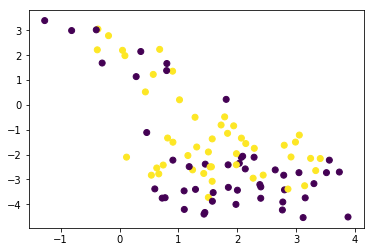

In [285]:
plt.scatter(w[1], w[2], c=c);